In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
X = read_csv('data/new-thyroid.csv', usecols=lambda col: col != 'class').values.tolist()
y = read_csv('data/new-thyroid.csv')['class'].values.tolist()

In [3]:
mn, mx = np.min(X, axis=0), np.max(X, axis=0)
X = [[(x[i] - mn[i]) / (mx[i] - mn[i]) if mx[i] > mn[i] else 0 for i in range(len(x))] for x in X]

In [4]:
dist_dict = {
    'manhattan': lambda a, b: sum([abs(_a - _b) for (_a, _b) in zip(a, b)]),
    'euclidean': lambda a, b: np.sqrt(sum([(_a - _b) ** 2 for (_a, _b) in zip(a, b)])),
    'chebyshev': lambda a, b: max([abs(_a - _b) for (_a, _b) in zip(a, b)])
}

cluster_distance_coefficients = {
    'single_linkage': lambda u, v, w, s: (0.5, 0.5, 0, -0.5),  
    'complete_linkage': lambda u, v, w, s: (0.5, 0.5, 0, 0.5),  
    'upgma': lambda u, v, w, s: (u / w,
                                 v / w,
                                 0,
                                 0),  
    'upgmc': lambda u, v, w, s: (u / w,
                                 v / w,
                                 - u * v / w ** 2,
                                 0),  
    'ward': lambda u, v, w, s: ((s + u) / (s + w),
                                (s + v) / (s + w),
                                -s / (s + w),
                                0)  
}

In [5]:
def f_score(labels, clusters):
    n = np.array([[0] * len(clusters) for _ in range(len(labels))])
    for j in range(len(clusters)):
        for i in clusters[j]:
            n[labels[i]][j] += 1
    
    p = n / np.sum(n)
    
    result = 0
    for j in range(len(clusters)):
        row_sum = np.sum(p, axis=1)
        col_sum = np.sum(p, axis=0)
        if np.isclose(col_sum[j], 0):
            continue
        result += col_sum[j] * np.max([(2 * p[i][j] ** 2 / (row_sum[i] * col_sum[j])) 
                                       / (p[i][j] / row_sum[i] + p[i][j] / col_sum[j]) 
                                       for i in range(len(labels)) 
                                       if not np.isclose(row_sum[i], 0) and not np.isclose(p[i][j], 0)])
        
    return result

In [6]:
def cluster_cohesion(X, clusters):
    result = 0
    for j in range(len(clusters)):
        cluster = clusters[j]
        x_avg = np.average([X[i] for i in cluster], axis=0)
        for i in cluster:
            x = X[i]
            result += np.sum([(x[k] - x_avg[k]) ** 2 for k in range(len(x))])
    return result

In [7]:
def distances_recalculation(r, u, v, s, clusters, cluster_dist):
    U, V, S = len(clusters[u]), len(clusters[v]), len(clusters[s])
    au, av, b, g = cluster_dist(U, V, U + V, S)
    
    return au * r[u][s] + av * r[v][s] + b * r[u][v] + g * abs(r[u][s] - r[v][s])

In [8]:
def hierarchy_union(r, clusters, cluster_dist):
    r_min = 1e20
    u, v = -1, -1
    for cur_u in range(len(clusters)):
        for cur_v in range(cur_u + 1, len(clusters)):
            if r[cur_u][cur_v] < r_min:
                r_min = r[cur_u][cur_v]
                u, v = cur_u, cur_v

    dists_to_s = np.array([distances_recalculation(r, u, v, s, clusters, cluster_dist) 
                           for s in range(len(clusters)) 
                           if s != u and s != v])
    W = clusters[u] + clusters[v]
    del clusters[u]
    del clusters[v if v < u else v - 1]
    r = np.delete(r, [u, v], axis=0)
    r = np.delete(r, [u, v], axis=1)
    
    clusters += [W]
    r = np.concatenate((r, dists_to_s[np.newaxis]), axis=0)
    r = np.concatenate((r, np.append(dists_to_s, 0)[np.newaxis].T), axis=1)
    
    return r, clusters

In [9]:
def hierarchy_clustering(X, cluster_dist, dist, clusters_count):
    clusters = [[i] for i in range(len(X))]
    r = np.array([[dist(u, v) for v in X] for u in X])
    
    f_scores = []
    cohesions = []
    result_clusters = []
    for i in tqdm(range(len(X) - 1)):
        r, clusters = hierarchy_union(r, clusters, cluster_dist)
        
        if len(clusters) == clusters_count:
            result_clusters = clusters.copy()
        
        f_scores.append(f_score(y, clusters))
        cohesions.append(cluster_cohesion(X, clusters))
    
    return result_clusters, f_scores, cohesions

In [10]:
def draw_clusters(X, clusters, title):
    for cluster in clusters:
        X_in_cluster = [X[i] for i in cluster]
        plt.scatter([x[0] for x in X_in_cluster], [x[1] for x in X_in_cluster], s=10)
    
    plt.title(title)
    plt.show()
    

In [11]:
pca = PCA(n_components=2)
transformed_X = pca.fit_transform(X)

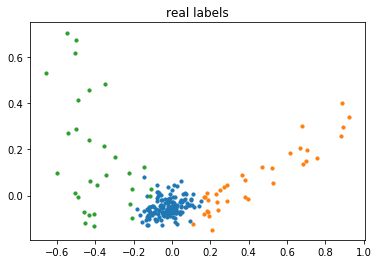

In [12]:
labels = [1, 2, 3]
real_labels = [[i for i in range(len(y)) if y[i] == label] for label in labels]
draw_clusters(transformed_X, real_labels, 'real labels')

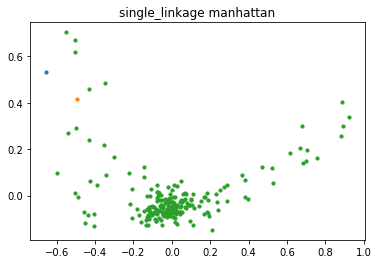

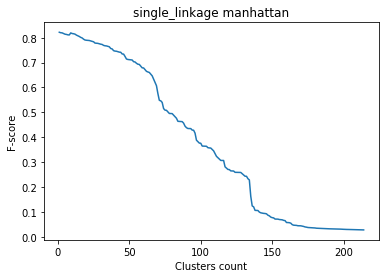

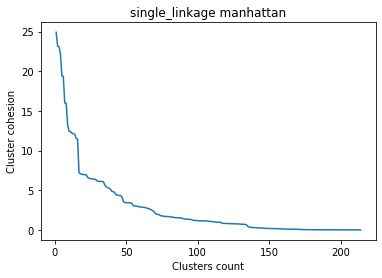

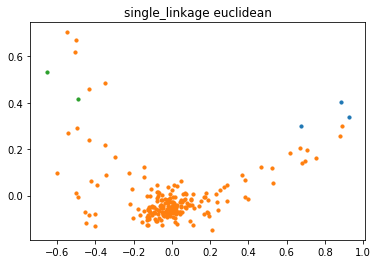

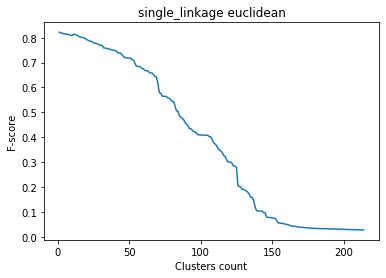

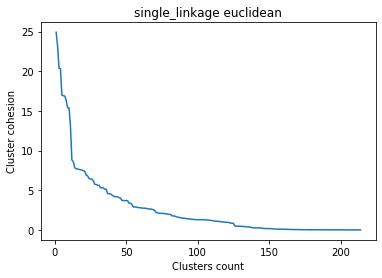

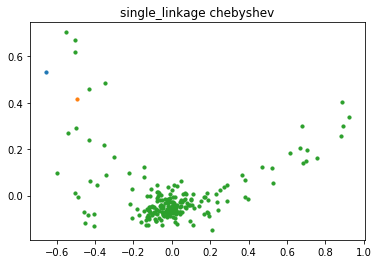

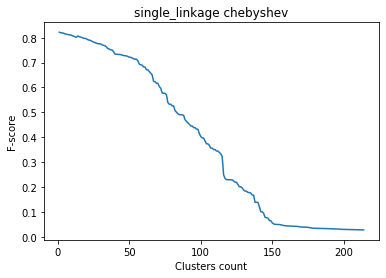

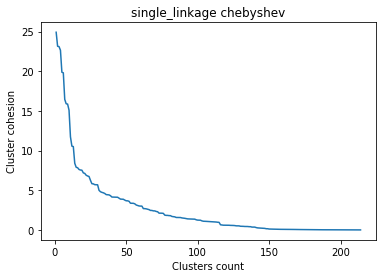

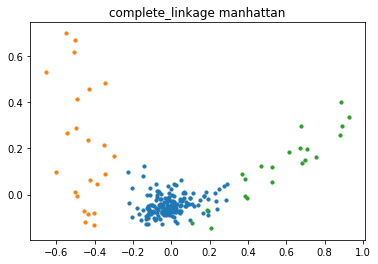

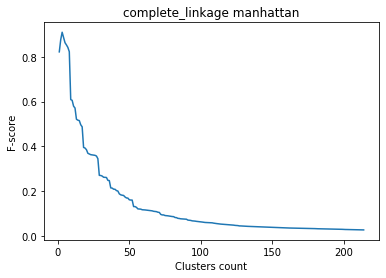

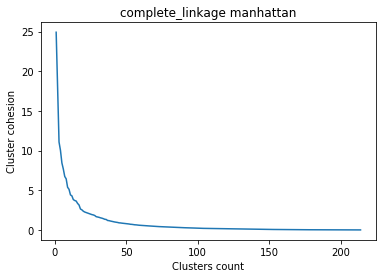

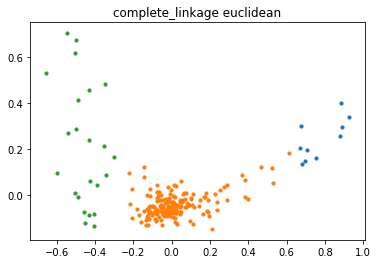

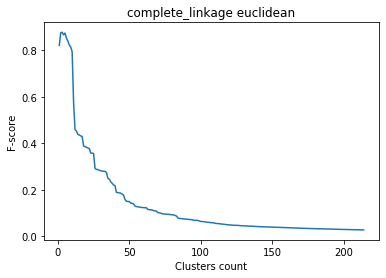

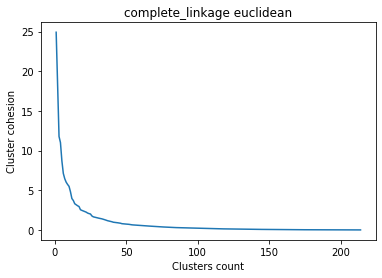

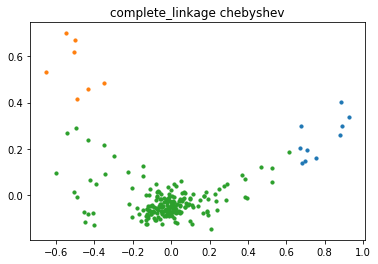

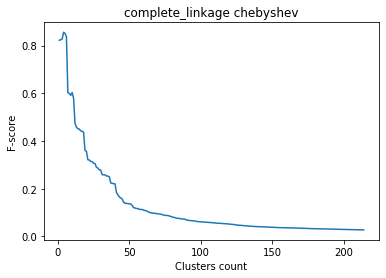

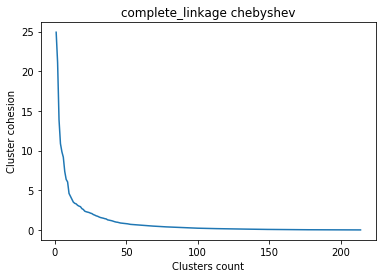

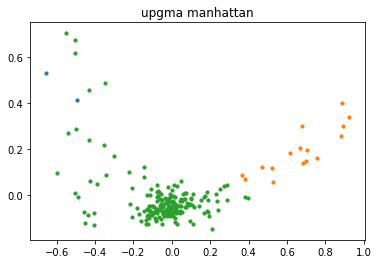

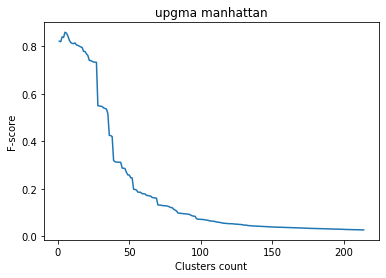

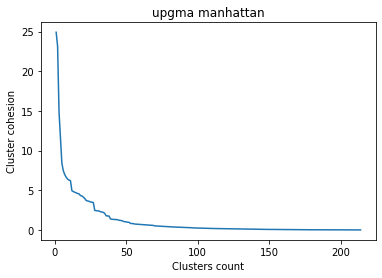

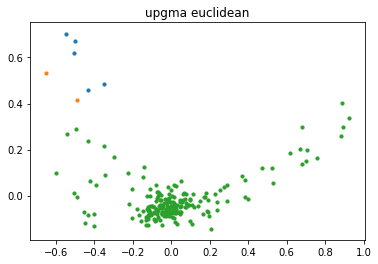

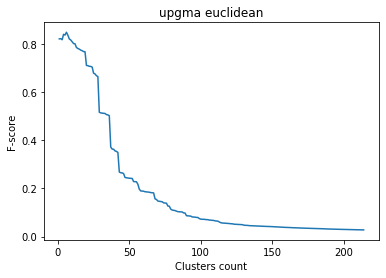

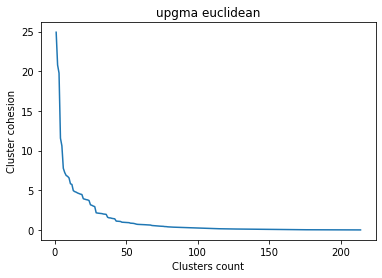

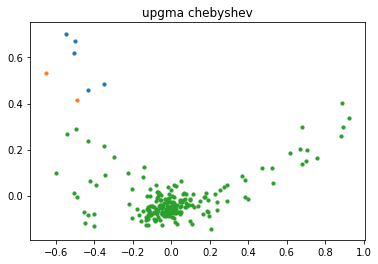

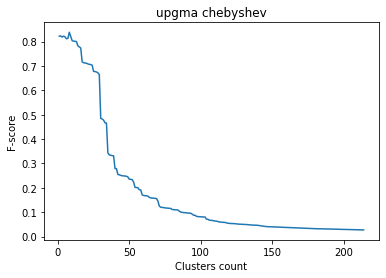

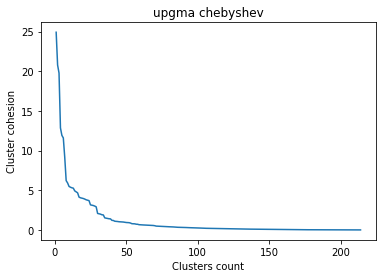

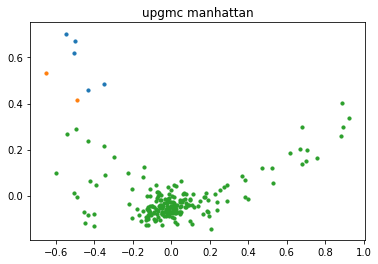

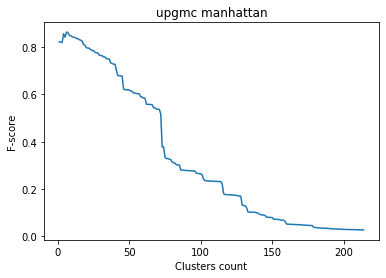

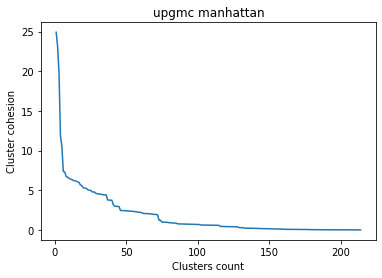

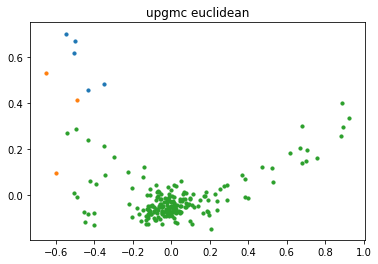

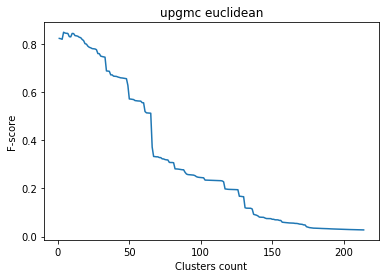

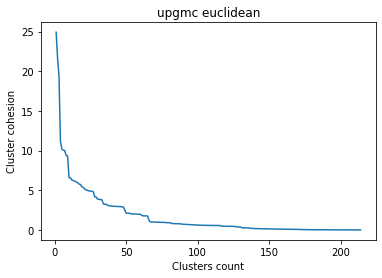

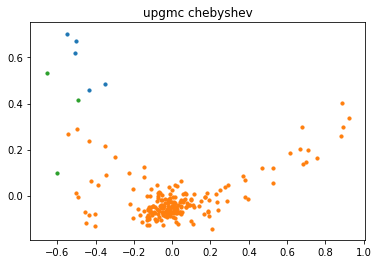

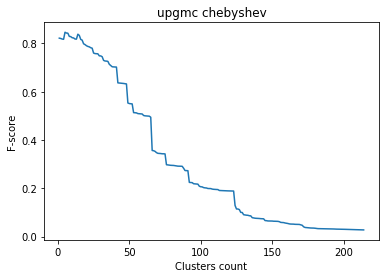

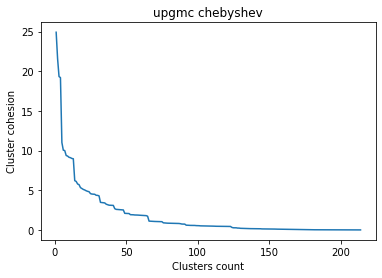

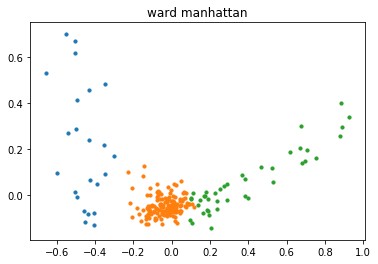

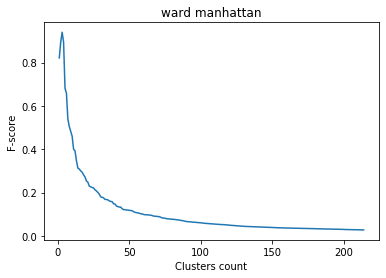

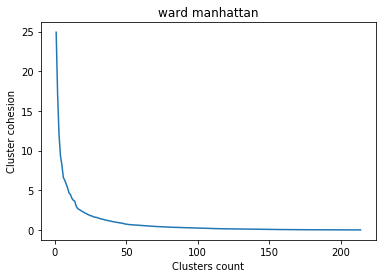

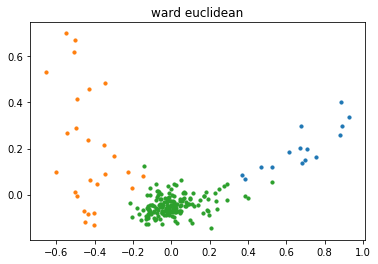

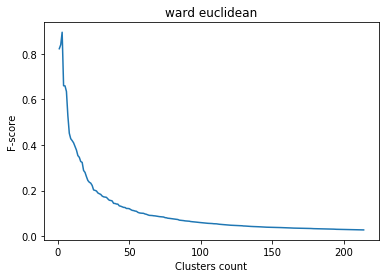

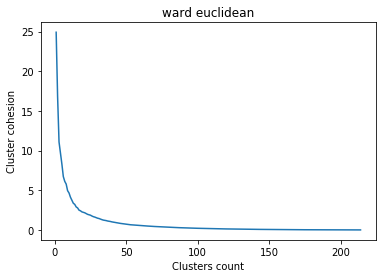

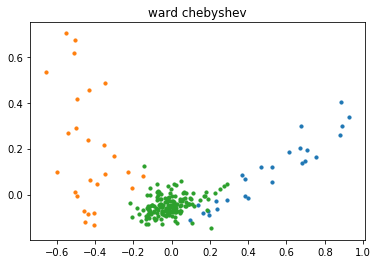

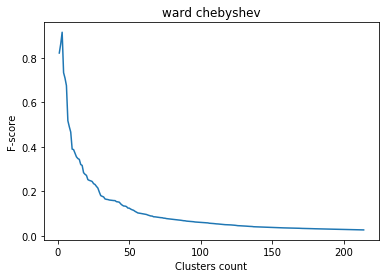

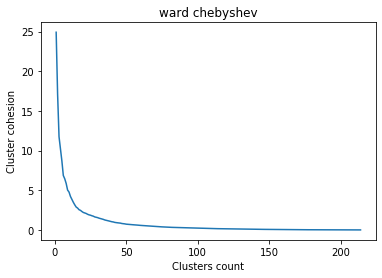

In [13]:
for cluster_dist_type, cluster_dist in cluster_distance_coefficients.items():
    for dist_type, dist in dist_dict.items():
        title = ' '.join([cluster_dist_type, dist_type])
        
        clusters, f_scores, cohesions = hierarchy_clustering(X, cluster_dist, dist, len(labels))
        draw_clusters(transformed_X, clusters, title)
        
        plt.plot([len(f_scores) - i for i in range(len(f_scores))], f_scores)
        plt.title(title)
        plt.xlabel('Clusters count')
        plt.ylabel('F-score')
        plt.show()
        
        plt.plot([len(cohesions) - i for i in range(len(cohesions))], cohesions)
        plt.title(title)
        plt.xlabel('Clusters count')
        plt.ylabel('Cluster cohesion')
        plt.show()
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYIAAAEWCAYAAABrDZDcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nO3deZhcZZ328e/d1Xt3Olt3ErKRlV0IENnXAQRRAR0XUBmY0UFnRGVcRpzxFV/UV8d9VBwHR0UdFVFRI+KAwyKLAumwBJIQCSGQhJB01s7W++/9o04nRdOddJI+Vd1d9+e66uqzPFX165NK3/Wc5TmKCMzMrHiVFLoAMzMrLAeBmVmRcxCYmRU5B4GZWZFzEJiZFTkHgZlZkXMQmB0gSVdKeiDfz93Da54ladVAvqYNbw4CM7Mi5yAwMytyDgLLO0khaVbO/E2SPpNMnyVplaR/kbRe0gpJ78hpO1bSbyU1S5ov6TO5u1aS1/5HSc9I2irp05JmSvpT8pxbJJUnbUdLuk1Sk6RNyfTkPdQ9RdKtSfsNkr7ZY/2Xktd5TtJrc5aPlPRdSWskrU5qzrz8qfqmpC2SnpZ0TrLwLZIW9HiPD0n6TTJ9oaTFye+5WtJHerT9sKR1yfv+bc7yiqTWFyStlfRtSVXJuiWSXp/TtjT5fY/ra7vY0OcgsMFoAlAPTAKuAG6UdGiy7gZge9LmiuTR0/nA8cBJwD8DNwLvBKYARwGXJe1KgO8DBwNTgZ3AN3u+GEDyh/s24HlgWlLbzTlNTgSWJnV/AfiuJCXrbgI6gFnAscBrgHf3eO6zyXOvA26VNAaYB0yXdHhO28uBHybT3wXeExEjkt/r7px2E4CRSZ3vAm6QNDpZ93ngEGBOUtMk4JPJup/mbB/Ibsv1EfFob9vFhomI8MOPvD6AAGblzN8EfCaZPovsH82anPW3AP8HyADtwKE56z4DPNDjtU/NmV8AfCxn/svA1/qoaw6wqY91JwNNQGkv664EluXMVyd1TADGA61AVc76y4B7cp77IqCc9Y8AlyfT/wF8Npk+EtgEVCTzLwDvAep61HMW2VArzVm2jmwwimyQzuzxuz2XTM8CtgLVyfyPgU8W+jPjR7oP9whsMNoUEdtz5p8HJgINQCmwMmdd7nS3tTnTO3uZrwWQVC3pPyU9L6kZuA8Y1WO3TbcpwPMR0dFHzS91T0TEjmSylmxvowxYI2mzpM3AfwLjcp67OpK/uj1+X4AfAG9PeheXA7dERGuy7q+BC4HnJf1R0sk5r7GhR607knoayAbVgpx6/idZTkQsA5YAb5BUDVwE/KSP39mGCQeBFcIOsn+Muk3osX60pJqc+alkvzU3ke0t5O7Hn3IAdXwYOBQ4MSLqgDOS5eql7UpgqqTSfXyPlWR7BPURMSp51EXEkTltJuXsRoLdvy8R8RDQBpwOvB34UXejiJgfEReTDZVfk+057c16smF4ZE49IyOiNqdN9+6hi4HFSTjYMOYgsEJ4nOy33IykC4Aze2nzfyWVSzodeD3w84joBG4FPpV8mz8M+JsDqGME2T+Km5N98tftoe0jwBrg85JqJFVKOnVvbxARa4A7gS9LqpNUkhy8zv2dxwEfkFQm6S3A4cDtOet/SPbYRXtEPACQbJt3SBoZEe1AM9DVj3q6gO8AX5U0LnmtSZLOz2l2M9njGP+AewNFwUFghfBB4A3AZuAdZL/N5nqJ7L7wF8nuo35vRDydrLua7EHQl8h+O/4p2W/c++NrQBXZb8kPkd1F0qskhN5Adh/6C8Aq4G39fJ+/AcqBxWR/r18AB+WsfxiYndTxWeDNEbEhZ/2PyB4M/u8er3s5sCLZrfVestuyPz4GLAMeSp77v2R7RsCu8PozcArws36+pg1hevmuSbPCknQW8N8R0edpnD3a/xswISJ6O3toWEhO7VwHHBcRzxS6Hht+3COwIUXSYZKOVtYJZE+N/FWh60rZPwDzHQKWln098GVWaCPI7g6aSPZsoC8DvyloRSmStILswetLClyKDWPeNWRmVuS8a8jMrMgNuV1D9fX1MW3atEKXYWY2pCxYsGB9RDT0tm7IBcG0adNobGwsdBlmZkOKpOf7WuddQ2ZmRc5BYGZW5BwEZmZFzkFgZlbkHARmZkXOQWBmVuQcBGZmRc5B0MO6rS385vHVhS7DzCxvHAQ9fO+BFXzw5sdZ+tLWQpdiZpYXDoIeGldsBOC2hS8WuBIzs/xwEORoae9k4aotANy2cA0emdXMisGQG2tofz3y3EZuW/giy5u2c9ExEzl55lh++sgLnDqrnlNn1QPw1OottHV2cc5h47jr6XUserGZoyaNLHDlZmbpKpogWLKmmVsfXc2YmnL++ZcLKcuI9s7gW/c+yxuPncRX3noMjc9vAuBfXnc4f/xLE79d+KKDwMyGvaIJgstOmMrlJx1MAN+6ZxlPr93Kh887hF8sWMW37n2W6fU1PLR8AzPqa5jZUMtps+v53cI1XHvBYUgqdPlmZqlJ9RiBpAskLZW0TNK1vayfKukeSY9JWijpwrRqKS8toaREZErE+8+ZzQ1vP44ZDbV89PxDufBVE/jKH/7Cn57dwCmzxgLw+qMnsmrTTh5fuTmtkszMBoXUegSSMsANwHnAKmC+pHkRsTin2SeAWyLiPyQdAdwOTEurpj7q5ItvPoZTZ9Uzo76W4w8eDcBrjhxP+a0l3LZwDcdOHZ3PkszM8irNXUMnAMsiYjmApJuBi4HcIAigLpkeCRTknM2ailLeceLBL1tWV1nGmYc28MM/r+CFjTs4cmIdU0ZXM3t8LUdPHlWIMs3MUpFmEEwCVubMrwJO7NHmU8Cdkt4P1ADnpljPPvvMJUfx7T8+y52L1vKHxWt3Lf/VP57iXoKZDRuFvo7gMuCmiJgMXAj8SNIrapJ0laRGSY1NTU15K258XSXXveFIHrz2r3j60xdwxzVnUF5awm+fWJO3GszM0pZmEKwGpuTMT06W5XoXcAtARPwZqATqe75QRNwYEXMjYm5DQ6/3Xk5dZVmGQyeM4IzZDdz+5Bq6unyxmZkND2kGwXxgtqTpksqBS4F5Pdq8AJwDIOlwskGQv6/8++H1Rx/ES80tPPrCpkKXYmY2IFILgojoAK4G7gCWkD07aJGk6yVdlDT7MPD3kp4AfgpcGYN8XIdzDh9HeWkJ37h7GTvaOgpdjpnZAdMg/7v7CnPnzo3GxsaC1vCDP63gU79dxOET6vj6Zccya1xtQesxM9sbSQsiYm5v6wp9sHhIuuKUaXzvilezZstOXvf1+3l4+YZCl2Rmtt8cBPvp7MPGccc1ZxABdy9dV+hyzMz2m4PgAIyrq2RcXQXrmlsLXYqZ2X5zEByg8XWVvLSlpdBlmJntNwfBAZpQV8narQ4CMxu6HAQHyLuGzGyocxAcoPF1lWxr7WBbq68pMLOhyUFwgCbUVQKwttm7h8xsaHIQHKBxdRWAg8DMhi4HwQEa7x6BmQ1xDoIDtDsIfMDYzIYmB8EBqq0opbai1D0CMxuyHAQDwKeQmtlQ5iAYABPqKnnJPQIzG6IcBANgfF0ly9Zt44mVmwtdipnZPkvz5vVF44pTpvGnZ9dz8Q0PMmlUFbPG1XLYQSN4xwkHM3VsdaHLMzPbo1RvTCPpAuDfgQzwXxHx+R7rvwqcncxWA+MiYtSeXnMw3JimN1tb2vnJwy+weE0zy9Zt45m12+iK4JzDx3HWoeOYNKqK4w8eTU2Fs9fM8m9PN6ZJ7a+SpAxwA3AesAqYL2leRCzubhMR/5TT/v3AsWnVk7YRlWW858yZu+bXNrfwnfuW89uFL3LHorUAjKwq4yOvOYTLT55WoCrNzF4pzWMEJwDLImJ5RLQBNwMX76H9ZWTvWzwsjK+r5BOvP4I/X3sO9330bH70rhOYNa6W629bTEt7Z6HLMzPbJc0gmASszJlflSx7BUkHA9OBu/tYf5WkRkmNTU1NA15omkpKxNSx1Zw+u4H3njmT9s7gydVbCl2Wmdkug+WsoUuBX0REr1+VI+LGiJgbEXMbGhryXNrAOW5q9vDHguc3FbgSM7Pd0gyC1cCUnPnJybLeXMow2i3Ul7G1Fcyor3EQmNmgkmYQzAdmS5ouqZzsH/t5PRtJOgwYDfw5xVoGjeMOHs2jz28izbO1zMz2RWpBEBEdwNXAHcAS4JaIWCTpekkX5TS9FLg5iuQv4/EHj2bD9jZuW7jG4xOZ2aCQ6nUEaRis1xH014r12zn7y/fSvdmPmTKKa86ZzVmHNiCpsMWZ2bC1p+sIHAQFsGrTDlZu3MljKzfx88ZVPLd+O5efdDCfvuSoQpdmZsNUQS4os75NHl3N5NHVnDxzLO8+bQaf+/0Svv/gCo6cWMelJ0wtdHlmVmQGy+mjRau8tIRPvO4ITptVz3XzFvliMzPLOwfBIJApEa85cjytHV1sb+0odDlmVmQcBINERWn2n6Klo6vAlZhZsXEQDBIVpRkAWr1ryMzyzEEwSFSWZf8pWt0jMLM8cxAMEt09Ah8sNrN8cxAMEt3HCNwjMLN8cxAMEhVlyTECB4GZ5ZmDYJDYddaQdw2ZWZ45CAYJHyw2s0JxEAwSPn3UzArFQTBIVJT5gjIzKwwHwSBRWeYegZkVRqpBIOkCSUslLZN0bR9t3ippsaRFkn6SZj2DmU8fNbNCSW0YakkZ4AbgPGAVMF/SvIhYnNNmNvBx4NSI2CRpXFr1DHblmRIk9wjMLP/S7BGcACyLiOUR0QbcDFzco83fAzdExCaAiFiXYj2DmiQqSkvcIzCzvEszCCYBK3PmVyXLch0CHCLpQUkPSbqgtxeSdJWkRkmNTU1NKZVbeBWlGQeBmeVdoQ8WlwKzgbOAy4DvSBrVs1FE3BgRcyNibkNDQ55LzJ+K0hJfUGZmeZdmEKwGpuTMT06W5VoFzIuI9oh4DvgL2WAoSpVl7hGYWf6lGQTzgdmSpksqBy4F5vVo82uyvQEk1ZPdVbQ8xZoGtewxAvcIzCy/UguCiOgArgbuAJYAt0TEIknXS7ooaXYHsEHSYuAe4KMRsSGtmga7irISWtrdIzCz/Ert9FGAiLgduL3Hsk/mTAfwoeRR9CpLM+4RmFneFfpgseWoKCuh1T0CM8szB8EgUlmaocU9AjPLMwfBIOIegZkVgoNgEPEFZWZWCA6CQaSyzBeUmVn+OQgGEfcIzKwQHASDiC8oM7NCcBAMIhVlGVrau8heXmFmlh8OgkGk++Y0bZ3ePWRm+eMgGER8lzIzKwQHwSDSfd9inzlkZvnkIBhEdvUIfFGZmeWRg2AQ6e4ReNeQmeWTg2AQ6e4ReNeQmeWTg2AQqXCPwMwKwEEwiFTuOkbgHoGZ5U+qQSDpAklLJS2TdG0v66+U1CTp8eTx7jTrGezcIzCzQkjtDmWSMsANwHlkb1I/X9K8iFjco+nPIuLqtOoYSnZfR+AegZnlT5o9ghOAZRGxPCLagJuBi1N8vyFv93UE7hGYWf6kGQSTgJU586uSZT39taSFkn4haUpvLyTpKkmNkhqbmprSqHVQcI/AzAqhX0Egabyk70r6fTJ/hKR3DcD7/xaYFhFHA38AftBbo4i4MSLmRsTchoaGAXjbwclDTJhZIfS3R3ATcAcwMZn/C3DNXp6zGsj9hj85WbZLRGyIiNZk9r+A4/tZz7DUvWtoW2tHgSsxs2LS3yCoj4hbgC6AiOgA9rb/Yj4wW9J0SeXApcC83AaSDsqZvQhY0s96hqXKsgx1laV86Y6lfOhnjzsQzCwv+hsE2yWNBQJA0knAlj09IQmLq8n2JJYAt0TEIknXS7ooafYBSYskPQF8ALhyP36HYSNTIu78pzP5+9Nn8JsnXuSSGx5kbXNLocsys2FO/bkJiqTjgG8ARwFPAQ3AmyNiYbrlvdLcuXOjsbEx32+bd396dj1Xfn8+Fx0zkS+95ZhCl2NmQ5ykBRExt7d1e+0RSCoBKoEzgVOA9wBHFiIEiskpM+u54uSDufXRVSxbt7XQ5ZjZMLbXIIiILuCGiOiIiEUR8VREtOehtqL3D2fNoqosw2XfeZgrv/8IW1u82c1s4PX3GMFdkv5aklKtxl5mTE05X7/sWGY21HDv0iaeWbet0CWZ2TDU3yB4D/BzoE1Ss6StkppTrMsS5xw+ng+/5lAAtvssIjNLQb/GGoqIEWkXYn2rKc/+M21v9RXHZjbw+j3oXHLK5xnJ7L0RcVs6JVlPNRXZC812tLlHYGYDr79DTHwe+CCwOHl8UNLn0izMdqvu7hG0uUdgZgOvvz2CC4E5yRlESPoB8Bjw8bQKs926ewQ+RmBmadiX0UdH5UyPHOhCrG9VZRkk2OEgMLMU9LdH8DngMUn3ACJ7rOAVdxyzdEiiprzUu4bMLBX9PWvop5LuBV6dLPpYRLyUWlX2CtXlGe8aMrNU9Pdg8RuBHRExLyLmAS2SLkm3NMtVU+EegZmlo7/HCK6LiF2jjUbEZuC6dEqy3tRUZHyMwMxS0d8g6K1daje+t1eqLi9lu68jMLMU9DcIGiV9RdLM5PFVYEGahdnL1ZRnfGWxmaWiv0HwfqAN+FnyaAHet7cnSbpA0lJJyyT1eZZRMqBdSOp1rGyD6gr3CMwsHf09a2g7yemikjJATbKsT0m7G4DzgFXAfEnzImJxj3YjyF61/PC+l188astL2eEegZmloL9nDf1EUp2kGuBJYLGkj+7laScAyyJieUS0ATcDF/fS7tPAv5HtZVgfqisy7hGYWSr6u2voiIhoBi4Bfg9MBy7fy3MmAStz5lcly3ZJboE5JSJ+t6cXknSVpEZJjU1NTf0seXipKS9le2sH/bm1qJnZvuhvEJRJKiMbBPOSO5Qd0F+k5BaYXwE+vLe2EXFjRMyNiLkNDQ0H8rZDVnVFhq6A1o6uQpdiZsNMf4PgP4EVQA1wn6SDgb3dmGY1MCVnfnKyrNsI4CjgXkkrgJOAeT5g3Lvaiu57Enj3kJkNrH4FQUR8PSImRcSFkd038QJw9l6eNh+YLWm6pHLgUmBezmtuiYj6iJgWEdOAh4CLIqJxv36TYa7aN6cxs5Tsy+ijAEi6LbL2+NU0WX81cAewBLglIhZJuj65yY3tg5ryZChqHzA2swG2P1cHT9p7k6yIuB24vceyT/bR9qz9qKVo1CS7hnyXMjMbaPvcIyB7QxrLs903p/GuITMbWHsMAklTey6LiL9Lrxzry+5jBO4RmNnA2luP4NfdE5J+mXIttgc1vm+xmaVkb0GgnOkZaRZie9a9a8jHCMxsoO0tCKKPacuzmgqfPmpm6djbWUPHSGom2zOoSqZJ5iMi6lKtznapKC2hRD5GYGYDb49BEBGZfBVie7b7BvYOAjMbWPtz+qgVSE1FKeu2tha6DDMbZhwEQ8h5R4zn9ifX8MhzGwtdipkNIw6CIeTa1x7GlNHV/OOPF/CxXyzkdwvX+CwiMztgvgH9EFJTUcq33nEcn//909yx+CV+1pi93cOo6jJ++HcncPTkUQWu0MyGIgfBEHPUpJH897tPpLMreGj5Bh5evoGv372MR5/f5CAws/3iXUNDVKZEnDqrnmvOPYTyTAlrmn2nTzPbPw6CIa6kREwYWcmazQ4CM9s/DoJh4KCRlazZsrPQZZjZEJVqEEi6QNJSScskXdvL+vdKelLS45IekHREmvUMV9kgcI/AzPZPakEgKQPcALwWOAK4rJc/9D+JiFdFxBzgC2RvZm/76KBRVaxtbqGry8NBmdm+S7NHcAKwLCKWR0QbcDNwcW6DiGjOma3BA9vtl4kjK2nvDNZv91XHZrbv0gyCScDKnPlV9HKbS0nvk/Qs2R7BB3p7IUlXSWqU1NjU1JRKsUPZhJFVAD5gbGb7peAHiyPihoiYCXwM+EQfbW6MiLkRMbehoSG/BQ4BB42sBPABYzPbL2kGwWpgSs785GRZX24GLkmxnmFrdxC4R2Bm+y7NIJgPzJY0XVI5cCkwL7eBpNk5s68DnkmxnmFrTE05FaUlDgIz2y+pDTERER2SrgbuADLA9yJikaTrgcaImAdcLelcoB3YBFyRVj3DmSQOGlnJs+u2sWFbK2NrKwpdkpkNIYoYWifqzJ07NxobGwtdxqBz+Xcf5v5n1iPBndecwezxIwpdkpkNIpIWRMTc3tYV/GCxDYzPvelVfO5NryIC7n9mfaHLMbMhxEEwTEweXc1lJ0xl8ugq37jGzPaJg2CYOXH6WB5ZsZGhtsvPzArHQTDMnDh9DBu3t7Fs3bZCl2JmQ4SDYJg5ccYYAP74lyb3CsysXxwEw8zUMdVMGlXFZ363hJM+dxdfvONpnlq9hU4PSGdmffDpo8PQyo07uO+ZJu5eso57lq6jK6A8U0LDiAomjqpk0qgqptXX8LZXT+GgZJwiMxve9nT6qINgmFu3tYU/LdvAkpeaWdfcyurNO1m9aSdrtuyktKSET77hCN550sGFLtPMUranIPDN64e5cSMqueTYSVzSY+DXlRt3cO2tC/n0bYs5fXY9B4+tKVCFZlZoPkZQpKaMqebLb5lDWaaED93yBN9/8DnuWrKWzTvaCl2ameWZewRFbMLISv7P6w/nX371FAue3wTAuBEV/OFDZzKyqqzA1ZlZvrhHUOTe9uqpLL7+fBZ84lxuvPx4mra18vW7PAisWTFxEBgVpRnG1lbwmiMn8La5U/jBn1awvMkXpJkVCweBvcyHzjuEzgh+t3BNoUsxszxxENjLjKur5MiJddy/zCOYmhULB4G9wqmz6nnshU1sb+0odClmlgepBoGkCyQtlbRM0rW9rP+QpMWSFkq6S5KvbBoETptVT3tn8MgKD2dtVgxSCwJJGeAG4LXAEcBlko7o0ewxYG5EHA38AvhCWvVY/7162hjKS0v4zWOrWfTiFtY1t3gAO7NhLM3rCE4AlkXEcgBJNwMXA4u7G0TEPTntHwLemWI91k+VZRlOmTmWXz/+Ir9+/EUA3njsJL7y1mOQVODqzGygpRkEk4CVOfOrgBP30P5dwO97WyHpKuAqgKlTpw5UfbYH33z7cTy9ppn121q5/5n1/PjhFzhl5ljeMndKoUszswE2KK4slvROYC5wZm/rI+JG4EbIDjqXx9KKVm1FKXOnZe9tcN4RE3i2aRv//MuFfOPuZXzmkqM445CGAldoZgMlzYPFq4Hcr4+Tk2UvI+lc4F+BiyKiNcV6bD9lSsS33nE8/3TuIWxv7eBHDz1f6JLMbACl2SOYD8yWNJ1sAFwKvD23gaRjgf8ELoiIdSnWYgdoTE05HzhnNuu2tnDro6tp7eikojRT6LLMbACk1iOIiA7gauAOYAlwS0QsknS9pIuSZl8EaoGfS3pc0ry06rGB8VeHjWNHWyePPOdTS82Gi1SPEUTE7cDtPZZ9Mmf63DTf3wbeyTPqqSgt4e6n13H6bB8nMBsOBsXBYhs6qsqTU0sfW83MhlpOmjGWSaOqqCwr8amlZkOUg8D22YdfcyjX3rqQT/z6qV3LKstKOHT8CK44ZRpvOm5yAaszs33lILB9dtSkkfz26tNYvKaZp9dsZe3WFtZvbePPyzfwoVueYMO2Ni4/+WAqy3ww2Wwo8M3rbcC0dnRy9U8e4w+L11JZVsJRE0cyrb6GEZWlTKirZNLoKg4dP4LZ40cUulSzouOb11teVJRm+PY7j+e+Z5r449ImFr24hQeeWc/Wlna2t3XuavdffzOXc48YX8BKzSyXg8AGVKZEnH3oOM4+dNzLlje3tLN6004+8NPHuP62xZw2u967jswGCd+PwPKirrKMww+q47o3HMkLG3fw/QdXFLokM0s4CCyvTptdzwnTxjDviRcLXYqZJRwElndnHtrAkjXNrNvaUuhSzAwHgRXAmcnIpQ884/simw0GDgLLuyMOqmNsTTn3/aWp0KWYGQ4CK4CSEnH67HruT04tNbPCchBYQbzpuMls2tHG67/xADc9+Bz3/aWJxS8209bRVejSzIqOryy2gpm/YiMf+fkTPL9hx65lFaUlzBpXS8OIChpqK7I/R1QwbkQlpx9ST11lWQErNhu6fGWxDUqvnjaGez9yFuu2tvL8hh2sbW7h8ZWbeW79dpq2tvL0mq2s39ZKR1f2y8rk0VV89o2vYkZ9DWNqyqkuz3jEU7MBkGqPQNIFwL8DGeC/IuLzPdafAXwNOBq4NCJ+sbfXdI+guHR1BZt3trP4xWY+9suFrN68c9e68tISxtaUM7q6nIvnTOSqM2Y4GMz6UJAegaQMcANwHrAKmC9pXkQszmn2AnAl8JG06rChraREjKkp57TZ9fz+mtN5ZPlGNu5oY+P2NjZtz/58bv12Pvf7p1netJ3rLjqC6nJ3dM32RZr/Y04AlkXEcgBJNwMXA7uCICJWJOt8hND2qq6yrNfB6iKCL925lBvueZYHlq3n4jkTmdlQy4yGGsbVVVJfW+77K5vtQZpBMAlYmTO/Cjhxf15I0lXAVQBTp0498MpsWJHER88/jDMPGcf/u30JN963fNdxhW4NIyqYPLqK+toKRlSWMrKqjEvmTOKYKaMKVLXZ4DEk+tARcSNwI2SPERS4HBukTpg+hl+/71TaO7tYuXEHy5u2s35bK2ubW1m9eQerN+9k1aadNO9sZ8P2Vn745+e5+uxZXP1XsyjL+ExqK15pBsFqYErO/ORkmVmqyjIlzGioZUZDbZ9tmlva+dS8Rfz7Xc9w99PrOPOQBuZOG81ZPYbPNisGaQbBfGC2pOlkA+BS4O0pvp9Zv9VVlvGVt87hvMPH85nfLeFb9y6jK+DtJ07ljcdOYvLoKuoqy3yKqhWFtE8fvZDs6aEZ4HsR8VlJ1wONETFP0quBXwGjgRbgpYg4ck+v6dNHLQ1tHV188Y6n+c79z71seaZEjKgspa6ybNfP848cz5WnTi9QpWb7Z0+nj/rKYrMc65pbeHL1FtY2t7K1pZ3mlna2tnTQvDP7c+WmHfxl7TZ+/O4TOXVWfaHLNes3X1ls1k/j6io5p66yz/Ut7Z1c+O/385GfP8GbjpvEWYeO49XTxuSxQrOB5x6B2T56fOVm3vfjR3mpuYXOruCSOROZPX4EdZWlTBxVxUkzxlJT4e9YNrh415BZCna2dfKlO6l9q9YAAAsESURBVJfyk4dfYGd7567lZRkxvb6GaWNrmN5Qw4z6Gk6cPpZp9TUFrNaKnYPALGUt7Z1sbengmbVbuX/Zepat28Zz67fz/IbttHdm/4/NmTKK+tpyxtZUMGFkJePrKqkuzzBpdBXHThlFqa9lsBT5GIFZyirLMlSWZWgYUcEpOQeROzq7WLlpJ7c98SL3PdPE6s0tPLFqC+u3tZL7HWxUdRlnHzqOQ8aPoKYiw7SxNYyuLqe8tGTXY3R1mcdRslS4R2BWAO2dXTRtbaWlvZOnX9rK/y5Zyz1Pr2PTjj3fsW1CXSUzGmpoGFFBdXmGEZVl1FWWMqKyjNqKUmorS3ed5jqmppyxHmfJEu4RmA0yZZkSJo6qAmBGQy0XvuogurqC1o4utra0s3z9dra2dNDW0UVbZyet7V1s2N7Gs03ZXU5PrNzM9rZOtra009K+5zEb6ypLqR9RQX1tBaOry7K9l9IMlWUlVJWX0jCigoNGVjJ5dBWHTaijvNS7qIqNg8BskCgpEVXlGarKM4zbwymsPbUl4bGttYOtLR1sa+1gy852Nm5vY/3WVtZva2X9tjaatrWyYv0OWjo6aWnvpKW9i51tnbR17g6SyrISZtTXMmVMFVPHVDMleUweVUVtZSnVZaVUlWccFsOMg8BsiCsvLWFsbQVjayv2+bkRweYd7bzU3MJz67ez4PlNLG/axrJ127h3aROtfdxDujQJreryDNXlpVSVZae7l1WVZagqL03WJ8vLkra5y5I22fa7n+thPfLLQWBWxCQxuqac0TXlHH5QHRe+6qBd67q6gqZtrazcmB25dXtrJzvaOtjZ1snO9k52tHWys62THe2d7GzrYEdb9sypdc2t7GjPttuRtN3XQ5GvCJby0iRIsst2r+8RNuUZqsp6LsvOV5ZmKCsV5ZkSMiVy2ORwEJhZr0pKxPi67GmuvR5h7KeIyO6Gat8dJDt2hUTH7uldP5Nl7Z20dLdNwual5vac53ews71z1+m5+0LKHqepyJRQVlpCWUaUl5ZQlimhPFOyazq7PEN5Rtl1u5aXUJHzvIrSTPKz5GXz2dfSrtctK33565cnr1GRKWxIOQjMLFXS7mMfY2rKB/z12zu7dgXJnsKmpb2L9s4u2ju6aOvMPto7grbOTto7gvbOLlqT9e0565t3ttOWLGvv7EoO4Meu6daOTroG8OTLniGVDZBsmFxz7iFcdMzEgXuzhIPAzIa0skwJI6tKGFlVVrAaOpLgaOvoDofsozssdgdI9/zuAGrr0WZ3IPVo09nF6Op0fkcHgZnZASrNlFCaKaF64Ds8eeFzwMzMilyqQSDpAklLJS2TdG0v6ysk/SxZ/7CkaWnWY2Zmr5RaEEjKADcArwWOAC6TdESPZu8CNkXELOCrwL+lVY+ZmfUuzR7BCcCyiFgeEW3AzcDFPdpcDPwgmf4FcI58cq+ZWV6lGQSTgJU586uSZb22iYgOYAswNsWazMyshyFxsFjSVZIaJTU2NTUVuhwzs2ElzSBYDUzJmZ+cLOu1jaRSYCSwoecLRcSNETE3IuY2NDSkVK6ZWXFKMwjmA7MlTZdUDlwKzOvRZh5wRTL9ZuDuGGo3SDAzG+JSvTGNpAuBrwEZ4HsR8VlJ1wONETFPUiXwI+BYYCNwaUQs38trNgHP70c59cD6/XheMfC22TNvn7552+zZYNo+B0dEr7tUhtwdyvaXpMa+7s5T7Lxt9szbp2/eNns2VLbPkDhYbGZm6XEQmJkVuWIKghsLXcAg5m2zZ94+ffO22bMhsX2K5hiBmZn1rph6BGZm1gsHgZlZkRv2QbC3obCLkaQVkp6U9LikxmTZGEl/kPRM8nN0oevMB0nfk7RO0lM5y3rdFsr6evJZWijpuMJVnh99bJ9PSVqdfH4eT64X6l738WT7LJV0fmGqzg9JUyTdI2mxpEWSPpgsH3Kfn2EdBP0cCrtYnR0Rc3LOcb4WuCsiZgN3JfPF4Cbggh7L+toWrwVmJ4+rgP/IU42FdBOv3D4AX00+P3Mi4naA5P/WpcCRyXO+lfwfHK46gA9HxBHAScD7km0w5D4/wzoI6N9Q2JaVOyT4D4BLClhL3kTEfWSvas/V17a4GPhhZD0EjJJ0UH4qLYw+tk9fLgZujojWiHgOWEb2/+CwFBFrIuLRZHorsITsiMpD7vMz3IOgP0NhF6MA7pS0QNJVybLxEbEmmX4JGF+Y0gaFvraFP0+7XZ3s3vhezm7Eot0+yd0VjwUeZgh+foZ7EFjvTouI48h2Vd8n6YzclcnAfz6vGG+LPvwHMBOYA6wBvlzYcgpLUi3wS+CaiGjOXTdUPj/DPQj6MxR20YmI1cnPdcCvyHbf13Z3U5Of6wpXYcH1tS38eQIiYm1EdEZEF/Addu/+KbrtI6mMbAj8OCJuTRYPuc/PcA+C/gyFXVQk1Uga0T0NvAZ4ipcPCX4F8JvCVDgo9LUt5gF/k5z9cRKwJWcXQNHosV/7jWQ/P5DdPpdKqpA0nexB0UfyXV++JLfV/S6wJCK+krNq6H1+ImJYP4ALgb8AzwL/Wuh6Cv0AZgBPJI9F3duE7C1C7wKeAf4XGFPoWvO0PX5KdvdGO9l9tu/qa1sAInsW2rPAk8DcQtdfoO3zo+T3X0j2j9tBOe3/Ndk+S4HXFrr+lLfNaWR3+ywEHk8eFw7Fz4+HmDAzK3LDfdeQmZnthYPAzKzIOQjMzIqcg8DMrMg5CMzMipyDwIY0SRMk3Szp2WTIjNslHSJpWu6Imfv4mldKmjjQteaDpH8pdA029DgIbMhKLuj5FXBvRMyMiOOBj3Pg4yRdCexTEEgqPcD3HCgOAttnDgIbys4G2iPi290LIuKJiLg/t1HyDf+bOfO3STpLUkbSTZKeSu7P8E+S3gzMBX6cjLVfJel4SX9Mehx35AwfcK+kryl7T4cPSnpL8lpPSLqvt4IlfSx5ryckfT5ZNkfSQ8kgbr/KGb/+Xklzk+l6SStyfp9bJf1PMub9F5Llnweqkrp/PFAb2Ya/wfItxmx/HAUsOIDnzwEmRcRRAJJGRcRmSVcDH4mIxmQsmW8AF0dEk6S3AZ8F/i55jfJI7ukg6Ung/IhYLWlUzzeT9FqyQxGfGBE7JI1JVv0QeH9E/FHS9cB1wDX9qP1YoBVYKukbEXGtpKsjYs7+bxIrRg4CK2bLgRmSvgH8DrizlzaHkg2cP2T3RJEhO+RCt5/lTD8I3CTpFuBWXulc4PsRsQMgIjZKGgmMiog/Jm1+APy8H7XfFRFbACQtBg7m5UMcm/Wbg8CGskXAm/vRroOX7watBIiITZKOAc4H3gu8ld3f9LsJWBQRJ/fx2tu7JyLivZJOBF4HLJB0fERs6Ndvsve6K3usa82Z7sT/l+0A+BiBDWV3AxU5N9dB0tGSTu/RbgUwR1KJpCkkwyZLqgdKIuKXwCeA7nvIbgVGJNNLgQZJJyfPKZN0ZG/FSJoZEQ9HxCeBJl4+5DDAH4C/lVSdtB+TfKvflFPz5UB372AFcHwy3Z/AA2hPdmeZ9Zu/RdiQFREh6Y3A1yR9DGgh+8ez5/71B4HngMVkbyf4aLJ8EvB9Sd1fiD6e/LwJ+LakncDJZP8Ifz3ZjVMKfI1sb6SnL0qaTbYXcRfZEV5z6/0fSXOARkltwO1kz/K5Inm/arK7q/42ecqXgFuSoPtdPzfLjcBCSY9GxDv6+Rwrch591MysyHnXkJlZkXMQmJkVOQeBmVmRcxCYmRU5B4GZWZFzEJiZFTkHgZlZkfv/AJhffvhtvK8AAAAASUVORK5CYII=